# BQ Onboarding Assignment - Nathan Li

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

## Data Collection & Preprocessing

In [7]:
# Companies to analyze
# tickers = ['LLY', 'NVO', 'JNJ', 'MRK', 'AZN', 'NVS', 'PFE', 'AMGN', 'SNY', 'BMY', 'GILD', 'VRTX', 'TMO', 'REGN']

tickers = [
 'NEE',
 'DUK',
 'SO',
 'D',
 'AEP',
 'EXC',
 'SRE',
 'NGG',
 'WEC',
 'PPL']

coint_start_date = "2022-01-01"
coint_end_date = "2024-01-01"

backtest_start_date = "2024-01-01"
backtest_end_date = "2025-01-01"

df = yf.download(tickers, start=coint_start_date, end=coint_end_date)['Close']

df_backtest = yf.download(tickers, start=backtest_start_date, end=backtest_end_date)['Close']

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


In [8]:
df.head()

Ticker,AEP,D,DUK,EXC,NEE,NGG,PPL,SO,SRE,WEC
Date,,,,,,,,,,
2022-01-03,78.364891,68.188316,91.643494,36.548061,84.811531,61.720779,27.181438,60.763351,60.112133,86.596558
2022-01-04,78.400261,67.970741,91.572655,36.509632,83.904739,61.840271,27.046162,60.763351,61.196041,86.380257
2022-01-05,79.125458,68.936775,91.776329,36.484020,83.025726,61.242786,27.100271,60.834656,61.569508,87.380585
2022-01-06,78.868980,68.806236,91.625786,36.330322,79.361603,60.628227,27.064198,60.763351,62.011276,86.830872
2022-01-07,80.301682,69.807091,92.537880,36.272686,79.953789,61.123283,27.280642,61.182278,62.944893,87.605896


In [9]:
df_backtest.head()

Ticker,AEP,D,DUK,EXC,NEE,NGG,PPL,SO,SRE,WEC
Date,,,,,,,,,,
2024-01-02,79.183723,46.157810,93.972870,35.010582,59.827850,63.885895,26.575058,68.335251,73.488289,83.059586
2024-01-03,79.374123,46.081696,94.904816,34.732189,60.235970,64.413406,26.719961,69.675919,73.672447,83.338631
2024-01-04,79.383636,45.862850,94.626198,34.578590,60.051342,64.978607,26.681322,69.164726,73.623985,82.674690
2024-01-05,80.030975,46.662121,94.674232,34.856991,60.323421,65.261200,26.806904,69.068283,74.079529,82.982605
2024-01-08,80.449829,46.633568,95.490891,35.221775,61.139645,65.157585,27.038748,69.598755,74.593231,82.337906


In [10]:
df.isnull().sum().sum()

0

In [11]:
df_backtest.isnull().sum().sum()

0

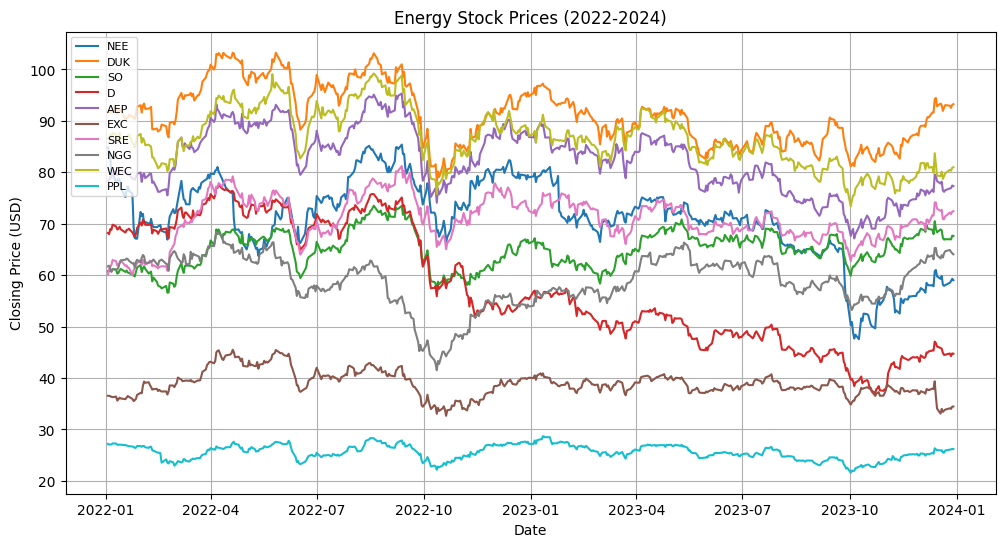

In [12]:
# Plot prices

plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(df.index, df[ticker], label=ticker)

# Formatting
plt.title("Energy Stock Prices (2022-2024)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)

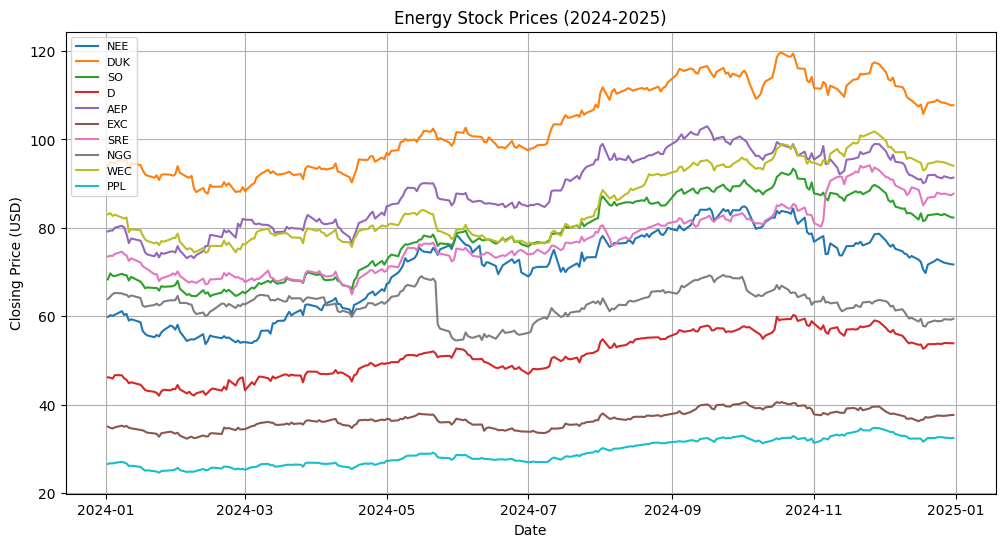

In [13]:
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(df_backtest.index, df_backtest[ticker], label=ticker)

# Formatting
plt.title("Energy Stock Prices (2024-2025)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)

## Testing for Cointegration

#### Step 1: Test for Stationarity
Augmented Dickey-Fuller Test

**Goal:** Identify non-stationary stocks, as cointegration requires at least one non-stationary stock.

**Method:** Apply the **Augmented Dickey-Fuller (ADF) test** to each stock’s price series.  

**Interpretation:**  
- **p-value < 0.05** → Stock **is stationary** (not useful for cointegration).  
- **p-value > 0.05** → Stock **is non-stationary** (candidate for cointegration).

In [14]:
from statsmodels.tsa.stattools import adfuller

# Function to check if a stock is stationary
def check_stationarity(series):
    p_value = adfuller(series.dropna())[1]  # Extract p-value
    return p_value

# Apply ADF test to all stocks
stationary_results = {stock: check_stationarity(df[stock]) for stock in df.columns}

# Filter only non-stationary stocks (p-value > 0.05)
non_stationary_stocks = [stock for stock, p_value in stationary_results.items() if p_value > 0.05]

print(f"Non-stationary stocks: {non_stationary_stocks}")

Non-stationary stocks: ['AEP', 'D', 'DUK', 'EXC', 'NEE', 'NGG', 'WEC']


#### Step 2: Engle-Granger Cointegration Test
**Goal:** Find pairs of non-stationary stocks that form a stationary spread.  

**Method:**  
1. **OLS regression:** Model one stock’s price as a function of another’s.  
2. **ADF test on residuals:** If stationary, the stocks are **cointegrated**.  

**Interpretation:**  
- **p-value < 0.05** → Stocks **are cointegrated**.  
- **p-value > 0.05** → Stocks **are not cointegrated**.  

In [15]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Ensure non_stationary_stocks contains column names
non_stationary_stocks = [stock for stock, p_value in stationary_results.items() if p_value > 0.05]

# Generate stock pairs correctly
stock_pairs = list(itertools.combinations(non_stationary_stocks, 2))
cointegrated_pairs = []

# Function to test cointegration
def test_cointegration(stock_x, stock_y):
    if stock_x not in df.columns or stock_y not in df.columns:
        print(f"Skipping invalid pair: {stock_x}, {stock_y}")
        return 1.0  # Return high p-value to skip

    # OLS Regression
    X = sm.add_constant(df[stock_x])
    model = sm.OLS(df[stock_y], X).fit()

    # Explicitly use the correct coefficient (hedge ratio)
    hedge_ratio = model.params[stock_x]  # Use stock name instead of index

    # Calculate residuals
    residuals = df[stock_y] - hedge_ratio * df[stock_x]

    # ADF test on residuals
    p_value = adfuller(residuals)[1]
    return p_value, hedge_ratio


# Run cointegration tests on valid stock pairs
for stock_x, stock_y in stock_pairs:
    p_value, hedge_ratio = test_cointegration(stock_x, stock_y)
    if p_value < 0.05:
        cointegrated_pairs.append((stock_x, stock_y, p_value, hedge_ratio))

print(f"Found {len(cointegrated_pairs)} cointegrated pairs.")


Found 5 cointegrated pairs.


#### Step 3: Rank Cointegrated Pairs

In [16]:
# Sort pairs by strongest cointegration (lowest p-value)
cointegrated_pairs_sorted = sorted(cointegrated_pairs, key=lambda x: x[2])[:10]

# Display pairs
print("Top Cointegrated Pairs:")
for pair in cointegrated_pairs_sorted:
    print(f"{pair[0]} - {pair[1]} | p-value: {pair[2]:.4f} | hedge-ratio: {pair[3]:.4f}")

Top Cointegrated Pairs:
AEP - WEC | p-value: 0.0021 | hedge-ratio: 0.8359
AEP - NEE | p-value: 0.0076 | hedge-ratio: 0.9952
D - EXC | p-value: 0.0207 | hedge-ratio: 0.1152
NEE - WEC | p-value: 0.0234 | hedge-ratio: 0.5138
D - WEC | p-value: 0.0394 | hedge-ratio: 0.3459


## Implementing Trading Strategy

**Goal**
Execute a **mean-reverting pairs trading strategy** using the **top cointegrated pairs** identified from the cointegration test.  
The strategy will be implemented **for a 1-year period** using hedge ratios derived from past regression.


#### Step 1: Compute Spread & Z-Score

**Goal**:
Calculate the **spread** between each stock pair and normalize it using a **Z-score** to detect deviations from the mean.

**Method**:
1. **Compute the spread** using the hedge ratio $(\beta)$:  
   $\text{Spread}_t = \text{Stock}_A - (\beta \times \text{Stock}_B)$
2. **Calculate the rolling mean & standard deviation** of the spread:
   - Mean: $\mu = \text{rolling mean of spread}$
   - Standard deviation: $\sigma = \text{rolling std deviation of spread}$
3. **Compute Z-score**:
   $Z_t = \frac{\text{Spread}_t - \mu}{\sigma}$
   - A high Z-score $(Z > 2)$ means the spread is unusually high.
   - A low Z-score $(Z < -2)$ means the spread is unusually low.


In [17]:
# Function to compute spread and Z-score
def compute_spread_zscore(stock_x, stock_y, hedge_ratio, df_backtest, window=30):
    spread = df_backtest[stock_x] - (hedge_ratio * df_backtest[stock_y])

    # Rolling mean & std for normalization
    spread_mean = spread.rolling(window).mean()
    spread_std = spread.rolling(window).std()

    # Compute Z-score
    z_score = (spread - spread_mean) / spread_std

    # Store results in DataFrame
    spread_df = pd.DataFrame({
        'Spread': spread,
        'Spread_Mean': spread_mean,
        'Spread_Std': spread_std,
        'Z_Score': z_score
    })

    return spread_df


#### Step 2: Define Entry & Exit Rules

Assume that if the spread deviates significantly, it will revert to the mean.

   - Short the spread when $Z > 2$
   - Long the spread (Buy Stock A, Sell Stock B) when $Z < -2$
   - Close the position when $Z$ returns to 0



In [18]:
def generate_trading_signals(spread_df, entry_threshold=2, exit_threshold=0):
    signals = pd.DataFrame(index=spread_df.index)
    signals['Z_Score'] = spread_df['Z_Score']

    # Long entry (buy stock A, sell stock B)
    signals['Long_Entry'] = signals['Z_Score'] < -entry_threshold
    # Short entry (sell stock A, buy stock B)
    signals['Short_Entry'] = signals['Z_Score'] > entry_threshold
    # Exit signal (close position when Z-score returns to mean)
    signals['Exit'] = (signals['Z_Score'] < exit_threshold) & (signals['Z_Score'] > -exit_threshold)

    return signals


#### Step 3: Simulate Trading & Compute PnL

1️. **Execute trades based on trading signals**  
   - When a **Long Entry** signal appears → Buy Stock A, Sell Stock B.  
   - When a **Short Entry** signal appears → Sell Stock A, Buy Stock B.  
   - Close trades when an **Exit signal** appears.

2️. **Calculate PnL (Profit & Loss)**
   - Compute **daily returns** from price movements.
   - Track **cumulative returns** over time.

3️. **Evaluate Strategy Performance**
   - Compare against **buy & hold** strategy.
   - Measure **Sharpe ratio, max drawdown, total return**.


In [19]:
# Function to simulate trading and compute PnL
def simulate_trading(signals, df_backtest, stock_x, stock_y, hedge_ratio, initial_capital=10000):

    portfolio = pd.DataFrame(index=signals.index)

    # Calculate daily returns for each stock
    portfolio['Returns_A'] = df_backtest[stock_x].pct_change()
    portfolio['Returns_B'] = df_backtest[stock_y].pct_change()

    # Positions: +1 = long, -1 = short, 0 = no position
    portfolio['Position'] = 0
    portfolio.loc[signals['Long_Entry'], 'Position'] = 1
    portfolio.loc[signals['Short_Entry'], 'Position'] = -1
    portfolio.loc[signals['Exit'], 'Position'] = 0

    # Carry forward positions until an exit signal occurs
    portfolio['Position'] = portfolio['Position'].replace(0, np.nan).ffill()

    # Compute PnL
    portfolio['PnL'] = portfolio['Position'].shift(1) * (portfolio['Returns_A'] - hedge_ratio * portfolio['Returns_B'])

    # Drop NaN values to avoid propagation
    portfolio['PnL'] = portfolio['PnL'].fillna(0)

    # Cumulative PnL Calculation
    portfolio['Cumulative_PnL'] = initial_capital * (1 + portfolio['PnL']).cumprod()


    return portfolio


#### Step 4: Performance Evaluation & Risk Analysis

In [20]:
# Function to compute performance metrics
def evaluate_performance(portfolio, risk_free_rate=0.02):
    """
    Evaluate strategy performance metrics.
    :param portfolio: DataFrame with cumulative PnL
    :param risk_free_rate: Assumed risk-free return for Sharpe Ratio
    :return: Dictionary with performance metrics
    """
    results = {}

    # Daily returns
    daily_returns = portfolio['PnL'].dropna()

    # Sharpe Ratio Calculation
    sharpe_ratio = (daily_returns.mean() - risk_free_rate / 252) / daily_returns.std()
    results['Sharpe Ratio'] = sharpe_ratio

    # Maximum Drawdown Calculation
    cumulative_returns = portfolio['Cumulative_PnL']
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    results['Max Drawdown'] = max_drawdown

    # Total Return Calculation
    total_return = (cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]) / cumulative_returns.iloc[0]
    results['Total Return'] = total_return

    return results


In [21]:
# Store performance results for all pairs
all_results = {}

# Loop through top 10 cointegrated pairs
for stock_x, stock_y, p_value, hedge_ratio in cointegrated_pairs_sorted:
    # print(f"\nTesting Pair: {stock_x} - {stock_y} | Hedge Ratio: {hedge_ratio:.4f}")

    # Compute Spread & Z-score
    spread_df = compute_spread_zscore(stock_x, stock_y, hedge_ratio, df_backtest)

    # Generate Trading Signals
    signals = generate_trading_signals(spread_df)

    # Simulate Trading & Compute PnL
    portfolio = simulate_trading(signals, df_backtest, stock_x, stock_y, hedge_ratio)

    # Evaluate Performance
    performance_results = evaluate_performance(portfolio)

    # Store results
    all_results[f"{stock_x} - {stock_y}"] = performance_results

# Print all results
print("\nSummary of Performance Metrics for Cointegrated Pairs:")
for pair, results in all_results.items():
    print(f"\n{pair}:")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")



Summary of Performance Metrics for Cointegrated Pairs:

AEP - WEC:
  Sharpe Ratio: -0.0816
  Max Drawdown: -0.1482
  Total Return: -0.1291

AEP - NEE:
  Sharpe Ratio: 0.0860
  Max Drawdown: -0.0834
  Total Return: 0.2984

D - EXC:
  Sharpe Ratio: 0.0464
  Max Drawdown: -0.1828
  Total Return: 0.1543

NEE - WEC:
  Sharpe Ratio: -0.0366
  Max Drawdown: -0.2568
  Total Return: -0.1128

D - WEC:
  Sharpe Ratio: 0.0829
  Max Drawdown: -0.1750
  Total Return: 0.2574


## Final Results

In [22]:
# Average return
# Extract total returns from strategy results
strategy_returns = [-0.1291, 0.2984, 0.1543, -0.1128, 0.2574]
average_strategy_return = sum(strategy_returns) / len(strategy_returns)

print(f"Average Strategy Return: {average_strategy_return:.4f}")

Average Strategy Return: 0.0936


In [37]:
# Comparison against general energy industry

benchmark = 'XLE'
benchmark_data = yf.download(benchmark, start=backtest_start_date, end=backtest_end_date)['Close']
benchmark_returns = (benchmark_data.iloc[-1].item() - benchmark_data.iloc[0].item()) / benchmark_data.iloc[0].item()
benchmark_returns

[*********************100%***********************]  1 of 1 completed


0.044380964251928515